In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import csv                               # csv reader
import re                                # regular expressions
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from random import shuffle
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.pipeline import Pipeline
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
def load_data(path):
    """
    Load data from a tab-separated file and append it to raw_data.
    """
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """
    Split the data between train_data and test_data according to the percentage
    and performs the preprocessing.
    """
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))
        
        

#Input and Basic preprocessing

In [5]:
def convert_label(label):
      """
      Converts the multiple classes into two, making it a binary distinction between fake news and real.
      """
      #return label
      # Converting the multiclass labels to binary label
      labels_map = {
          'true': 'REAL',
          'mostly-true': 'REAL',
          'half-true': 'REAL',
          'false': 'FAKE',
          'barely-true': 'FAKE',
          'pants-fire': 'FAKE'
      }
      return labels_map[label]


def parse_data_line(data_line):
    label=convert_label(data_line[1])
    statement=data_line[2]
    return (label, statement)

In [6]:
# TEXT PREPROCESSING AND FEATURE VECTORIZATION
ps = PorterStemmer()
# input: a string of one review
def pre_process(text):
    """
    Here word tokenizer from nltk library splits the text into token of words using defined 
    punctuation in the nltk library and Porter Stemmer converts the tokenized text words into their root 
    form and this is returned in the form of list.
    """  
    tokens = word_tokenize(text)  # Splits the words into tokens
    words1=[]
    for word in tokens:
      words1.append(re.sub('[^a-zA-z]','',word)) #Removing all the puncuation marks
    token_words = [ps.stem(word) for word in words1]  #Stemming
    return token_words

print(pre_process("hello ! How can I help you ?"))

['hello', '', 'how', 'can', 'i', 'help', 'you', '']


#  Basic Feature Extraction

In [7]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
  """
  Global feature dictionary helps us to track number of features in the dataset a unique index is 
  assigned if word appears only once if a word is present in the dictionary then its index is used.
   Local feature dictionary calculates term frequency of the words i.e., number of times a word occurs in the document 
   by total number of words in the dictionary.Term frequency is generally used to normalize the text in the document.
   """
  f_v = {} #local dictionary of features
  for t in tokens:
        if t not in global_feature_dict:
            global_feature_dict[t] = len(global_feature_dict) + 1
        
        rep = global_feature_dict[t]
        #term frequency method
        if rep not in f_v:
            f_v[rep] = (1 / len(tokens))
        else:
            f_v[rep] += (1 / len(tokens))

  return f_v

print(to_feature_vector(['hello', 'how', 'how','can', 'can','i','i', 'help', 'you']))  

{1: 0.1111111111111111, 2: 0.2222222222222222, 3: 0.2222222222222222, 4: 0.2222222222222222, 5: 0.1111111111111111, 6: 0.1111111111111111}


In [8]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def train_classifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainData)

In [9]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """
    Assuming preprocessed samples, return their predicted labels from the classifier model.
    """
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """
    Assuming raw text, return its predicted label from the classifier model.
    """
    return classifier.classify(to_feature_vector(pre_process(sample)))

# Cross-validation

In [10]:
#cross validation
# from sklearn.metrics import classification_report
fold1_val_label=[]
fold1_val_pred=[]
def cross_validate(dataset, folds):
    shuffle(dataset)
    results = []
    fold_size = int(len(dataset)/folds) + 1
    cv_accuracy=0
    # fold1_dict = {"fold1_val_data":[], "fold1_true_label":[], "fold_pred":[],
    #               "False_Positive":[], "False_Negative": []}
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        accuracy=0
        train_data = dataset[ i + fold_size:]+dataset[ : i]
        val_data = dataset[i:i+fold_size]
        classifier = train_classifier(train_data)
        val_label = [x[1] for x in val_data]
        val_data1 = [x[0] for x in val_data]
        val_pred = predict_labels(val_data1, classifier)
        #precision, recall, fscore, _ = metrics.precision_recall_fscore_support(validation_labels, predicted_labels, average='weighted')
        results.append(precision_recall_fscore_support(val_label, val_pred, average='weighted'))
        accuracy = metrics.accuracy_score(val_label, val_pred)
        cv_accuracy+=accuracy

    #cv_results consits of average precision, recall,fscore, accuracy              
    cv_Results = [np.mean([x[0] for x in results]),
                   np.mean([x[1] for x in results]),
                   np.mean([x[2] for x in results]),
                   cv_accuracy/folds
                ]
    """
    STEPS:
        1.for the cross validation, data set is divided into 10 folds, for each fold a training and validation data is created. 
        2. Here i is increment by fold size in each iteration untill length of the dataset. 
           suppose i =1 and fold size is 100 validation data is collected from data having index [1 + (1+foldsize):] and training data is collected 
            from index [0:1]+[1+foldsize:]. 
        3.Linear SVM classifier trains on the training data.
        4.labels and data is collected from the validation data for further prediction.
        5.precision, recall, fscore and support is calculated using validation labels and labels predicted from the classifier.
        6.accuracy is found using the metrics. 
        7. for each iteration from the step 2 all the steps are repeated.
        8. average results are calculated for each metrics and returned in the form of lists 
    """
        
    return cv_Results

In [12]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 4462 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 4462 rawData, 3569 trainData, 893 testData
Training Samples: 
3569
Features: 
5932


In [13]:
cv_results = cross_validate(train_data, 10)
print('Precision_score: {0}\n Recall_score: {1}\n FScore: {2}\nAccuracy: {3}'.format(cv_results[0], cv_results[1], cv_results[2],cv_results[3]))

Fold start on items 0 - 357
Training Classifier...
Fold start on items 357 - 714
Training Classifier...
Fold start on items 714 - 1071
Training Classifier...
Fold start on items 1071 - 1428
Training Classifier...
Fold start on items 1428 - 1785
Training Classifier...
Fold start on items 1785 - 2142
Training Classifier...
Fold start on items 2142 - 2499
Training Classifier...
Fold start on items 2499 - 2856
Training Classifier...
Fold start on items 2856 - 3213
Training Classifier...
Fold start on items 3213 - 3570
Training Classifier...
Precision_score: 0.6005216499417911
 Recall_score: 0.6024179334655211
 FScore: 0.585279306234991
Accuracy: 0.6024179334655211


# Error Analysis

In [14]:
#error analysis
from sklearn.metrics import classification_report
def get_sentence(sentence):
  #retracing tokens from the global_feature_dictionary defined in the feature vector function
    ids = list(sentence.keys())    
    words = []
    for w, id in global_feature_dict.items():
        if id in ids:
            words.append(w)
    return words

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
labels=['FAKE','REAL']
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [17]:
# take one fold for analysis
fold_size = int(len(train_data)/10) + 1
i = 0 # take first fold
print("Fold start on items %d - %d" % (i, i+fold_size))
fold_test_data = train_data[i:i+fold_size]
fold_train_data = train_data[:i] + train_data[i+fold_size:]
classifier = train_classifier(fold_train_data)
y_true = [x[1] for x in fold_test_data]
y_pred = predict_labels([x[0] for x in fold_test_data], classifier)
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(classification_report(y_true,y_pred))

Fold start on items 0 - 357
Training Classifier...
(0.6237710770582743, 0.6358543417366946, 0.621501896887112, None)
              precision    recall  f1-score   support

        FAKE       0.56      0.40      0.47       142
        REAL       0.67      0.79      0.72       215

    accuracy                           0.64       357
   macro avg       0.61      0.60      0.60       357
weighted avg       0.62      0.64      0.62       357



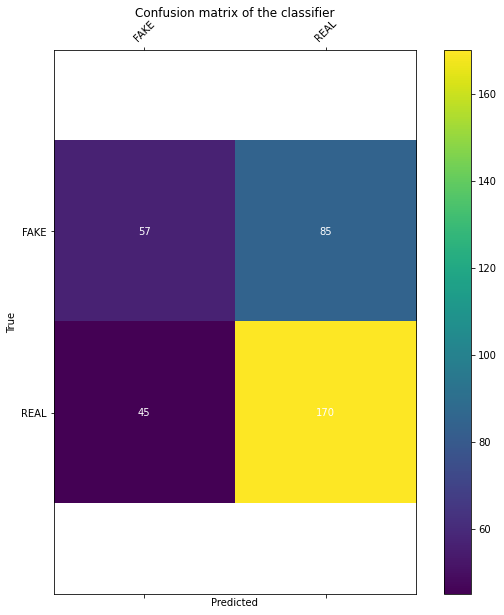

In [19]:
confusion_matrix_heatmap(y_true, y_pred,labels=labels)

we have 45 false negatives and 85 false postives

In [20]:
classifier=train_classifier(train_data[820:])
featuresets_val=[]
labelsets_val=[]
for val_ix in [x for x in list(range(0,820,1))]:
  (features,labels) = train_data[val_ix]
  featuresets_val.append(features)
  labelsets_val.append(labels)
predictionsets = predict_labels(featuresets_val, classifier)  

Training Classifier...


# False positives for FAKE (which real news is being falsely classified as fake)

In [21]:
for (sentence, true, predicted) in zip(raw_data[0:820],labelsets_val,predictionsets):
  if true == 'FAKE':
    if predicted == 'REAL':
      print(f'Sentence:{sentence[0]} Ground Truth : {true} Predicted : {predicted}')

Sentence:Health care reform legislation is likely to mandate free sex change surgeries. Ground Truth : FAKE Predicted : REAL
Sentence:When Mitt Romney was governor of Massachusetts, we didnt just slow the rate of growth of our government, we actually cut it. Ground Truth : FAKE Predicted : REAL
Sentence:Most of the (Affordable Care Act) has already in some sense been waived or otherwise suspended. Ground Truth : FAKE Predicted : REAL
Sentence:McCain opposed a requirement that the government buy American-made motorcycles. And he said all buy-American provisions were quote 'disgraceful.'  Ground Truth : FAKE Predicted : REAL
Sentence:Says Scott Walker favors cutting up to 350,000 families and children off health care. Ground Truth : FAKE Predicted : REAL
Sentence:We cut business taxes so today 70 percent of our businesses dont pay a business tax. Ground Truth : FAKE Predicted : REAL
Sentence:Says Ohio budget item later signed into law by Gov. John Kasich requires women seeking an abortio

# False negatives for FAKE 

In [22]:
for (sentence, true, predicted) in zip(raw_data[0:820],labelsets_val,predictionsets):
  if true == 'FAKE':
    if predicted == 'FAKE':
      print(f'Sentence:{sentence[0]} Ground Truth : {true} Predicted : {predicted}')

Sentence:Hate crimes against American Muslims and mosques have tripled after Paris and San Bernardino. Ground Truth : FAKE Predicted : FAKE
Sentence:Rick Perry has never lost an election and remains the only person to have won the Texas governorship three times in landslide elections. Ground Truth : FAKE Predicted : FAKE
Sentence:In the case of a catastrophic event, the Atlanta-area offices of the Centers for Disease Control and Prevention will self-destruct. Ground Truth : FAKE Predicted : FAKE
Sentence:Says Marco Rubio skipped 18 defense votes including one to arm the Kurds to fight ISIS. Ground Truth : FAKE Predicted : FAKE
Sentence:President Barack Obama took exactly none of his own deficit reduction commissions ideas. Not one. Ground Truth : FAKE Predicted : FAKE
Sentence:It was under Barack Obama and Hillary Clinton that changed the rules of engagement that probably cost (Capt. Humayun Khans) life. Ground Truth : FAKE Predicted : FAKE
Sentence:Only 2 percent of public high school

After looking at the FN file, there are several observations:
* Claims about groups and/or foreign countries (to the USA) are prevalent (e.g. "Blocking travel from countries with Ebola should be possible because President Barack Obama has sealed off Israel in the past." 
* Possibly sentiment is stronger than in the FNs with stronger claims, possibly exaggerated ("Under Greg Abbott, Texas four-year-olds would be forced to undergo standardized tests." "Poll after poll after poll shows me beating Hillary.")
* Many numerical claims again, though in different formats. May be more extreme numerical claims or vague compared to the other REAL TPs - in either way, given different formats need to join represent numerical claims in a similar way whether in figures or in words if there is something about the nature of the claims which means they're fake
